In [71]:
%load_ext autoreload
%autoreload 2

import os

from TaylorF2_standalone import TaylorF2
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run§§ the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [73]:
# Waveforms will be parametrized by 2 random numbers: mass ratio and spin
n_train = 20000
n_test = 2000

q_train = np.random.uniform(.10,10.0,n_train)
chi1_train = np.random.uniform(-1.,1.,n_train)
y_train = np.vstack((q_train,chi1_train))

q_test = np.random.uniform(1.0,10.0,n_test)
chi1_test = np.random.uniform(-1.,1.,n_test)
y_test = np.vstack((q_test,chi1_test))

In [74]:
def get_component_from_chirp(M_chirp,q):
    """Convert chirp mass and mass ratio to component masses"""
    m2 = ((((q+1)**(1./5.))/(q**(3./5.)))*M_chirp)
    m1 = q*m2
    return m1,m2

chi2 = 0.0 # spin zero
Mchir = 1.0 # chirp mass

n_points = 200
rescaling = 1e3 # Neural networks seem to work better with normalized data

Mf_max = 1.0/(6**(3.0/2.0) * np.pi) # cut at ISCO
Mf_array = np.linspace(1e-3, Mf_max, n_points) # Geometric frequency

x_train = np.empty((n_train, n_points))
for i,(q,chi1) in enumerate(y_train.transpose()):
    m1,m2 = get_component_from_chirp(Mchir,q)
    pn = TaylorF2(m1, m2, chi1, chi2)
    x_train[i] = pn.compute_strain(Mf_array, Mf0=0.01)/rescaling
    
x_test = np.empty((n_test, n_points))
for i,(q,chi1) in enumerate(y_test.transpose()):
    m1,m2 = get_component_from_chirp(Mchir,q)
    pn = TaylorF2(m1, m2, chi1, chi2)
    x_test[i] = pn.compute_strain(Mf_array, Mf0=0.01)/rescaling

/Users/Rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/Rhys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


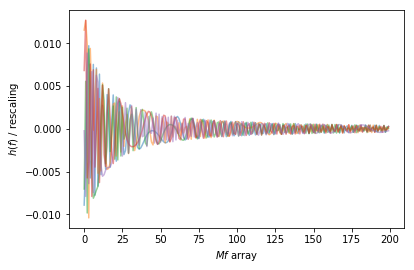

In [75]:
for curve in x_train[0:5]:
    plt.plot(curve , alpha = 0.5)
plt.xlabel(r'$Mf$ array')
plt.ylabel(r'$ h(f)$ / rescaling')
plt.show()

In [76]:
x_train = torch.tensor(x_train)
#x_train = x_train.numpy()
x_test = torch.tensor(x_test)
#x_test = x_test.numpy()

In [77]:
 with pyro.iarange('data ', len(x_train) 
                      ,subsample_size =100) as ind :
        batch = x_train[ind]


In [78]:
batch.shape

torch.Size([100, 200])

In [79]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    train_set = x_train
    test_set = x_test
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [80]:
train_loader , test_loader = setup_data_loaders(batch_size=100
                                                , use_cuda=False)
train_loader

In [82]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_points)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 200
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [83]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_points, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, n_points)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [84]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size) :
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [85]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [86]:
def train(svi, training_data, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for i, (x) in enumerate(training_data):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        print(x[i])
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
        
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [68]:
# def train(svi, training_data, use_cuda=False):
#     # initialize loss accumulator
#     epoch_loss = 0.
#     #print(training_data[0])
#     # do a training epoch over each mini-batch x returned
#     # by the data loader
#     with pyro.iarange('data ', len(training_data) 
#                       ,subsample_size =100) as ind :
#         batch = x_train[ind]
#         #print(batch.size)
#         # if on GPU put mini-batch into CUDA memory
#         # do ELBO gradient and accumulate loss
#         print(batch.shape)
#         epoch_loss += svi.step(batch)
    
#     # return epoch loss
#     normalizer_train = len(training_data)
#     total_epoch_loss_train = epoch_loss / normalizer_train
#     return total_epoch_loss_train

In [87]:
train_loss = train(svi, x_train, use_cuda=False)

tensor(1.00000e-03 *
       -8.9188, dtype=torch.float64)


TypeError: 'builtin_function_or_method' object cannot be interpreted as an integer

In [ ]:
def evaluate(svi, test_data, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x) in enumerate(test_data):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_data)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


In [ ]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [ ]:
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, x_test, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))